In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import sys
import networkx as nx
import os
import warnings
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

sys.path.append(
    '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/experiment_graph/'
)

# Experiment Graph
import execution_environment 
reload(execution_environment)
from execution_environment import ExecutionEnvironment as ee
# Suppress warnings
warnings.filterwarnings('ignore')
% matplotlib inline

def plot_graph():
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(ee.graph.graph)
    #pos = graphviz_layout(ee.graph.graph, prog='twopi', args='')
    color_map = []
    for node in ee.graph.graph.nodes(data=True):

        if node[1]['root']:
            color_map.append('green')
        elif node[1]['type'] == 'Dataset' or node[1]['type'] == 'Feature':
            color_map.append('red')
        elif node[1]['type'] == 'Agg' or node[1]['type'] == 'SK_Model':
            color_map.append('blue')
        elif node[1]['type'] == 'SuperNode':
            color_map.append('grey')
        else:
            color_map.append('black')

    nx.draw(ee.graph.graph,
            node_color=color_map,
            pos=pos,
            node_size=100)
    nx.draw_networkx_edge_labels(ee.graph.graph,
                                 pos=pos,
                                 edge_labels={(u, v): d["name"] for u, v, d in ee.graph.graph.edges(data=True)})
    plt.show()

def get_size(graph):
    def get_mb(df):
        to_mb = (1024*1024)
        if isinstance(df, pd.DataFrame):
            return sum(df.memory_usage(index=True, deep=True))/to_mb
        elif isinstance(df, pd.Series):
            return df.memory_usage(index=True, deep=True)/to_mb
        else:
            return sys.getsizeof(df)/to_mb
    
    t_size = 0
    for node in graph.nodes(data=True):
        t_size += get_mb(node[1]['data'].data)
    return t_size

        


In [3]:
%%time
ROOT_DIRECTORY = '../../data/home-credit-default-risk'
print(os.listdir(ROOT_DIRECTORY))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']
CPU times: user 548 µs, sys: 638 µs, total: 1.19 ms
Wall time: 619 µs


In [4]:
%%time
app_train = ee.load(ROOT_DIRECTORY + '/application_train.csv')
print('Training data shape: ', app_train.shape().get())
app_train.head().get()

('Training data shape: ', (307511, 122))
CPU times: user 4.36 s, sys: 399 ms, total: 4.76 s
Wall time: 4.78 s


In [5]:
%%time
app_test = ee.load(ROOT_DIRECTORY + '/application_test.csv')
print('Testing data shape: ', app_test.shape().get())
app_test.head().get()

('Testing data shape: ', (48744, 121))
CPU times: user 692 ms, sys: 53.6 ms, total: 745 ms
Wall time: 746 ms


In [6]:
%%time
app_train['TARGET'].value_counts().get()

CPU times: user 6.52 ms, sys: 2.76 ms, total: 9.28 ms
Wall time: 10.1 ms


0    282686
1     24825
Name: TARGET, dtype: int64

CPU times: user 83.7 ms, sys: 10.8 ms, total: 94.5 ms
Wall time: 96.1 ms


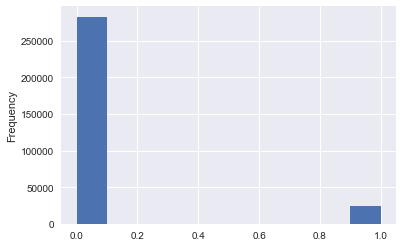

In [7]:
%%time
app_train['TARGET'].get().astype(int).plot.hist()

In [8]:
%%time
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().get()
    
    mis_val_percent = 100 * mis_val / len(dataset.get())
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [9]:
%%time
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
CPU times: user 874 ms, sys: 81.8 ms, total: 956 ms
Wall time: 960 ms


In [9]:
%%time
app_train.meta['dtypes'].value_counts()

CPU times: user 1.08 ms, sys: 175 µs, total: 1.25 ms
Wall time: 1.15 ms


float64    65
int64      41
object     16
dtype: int64

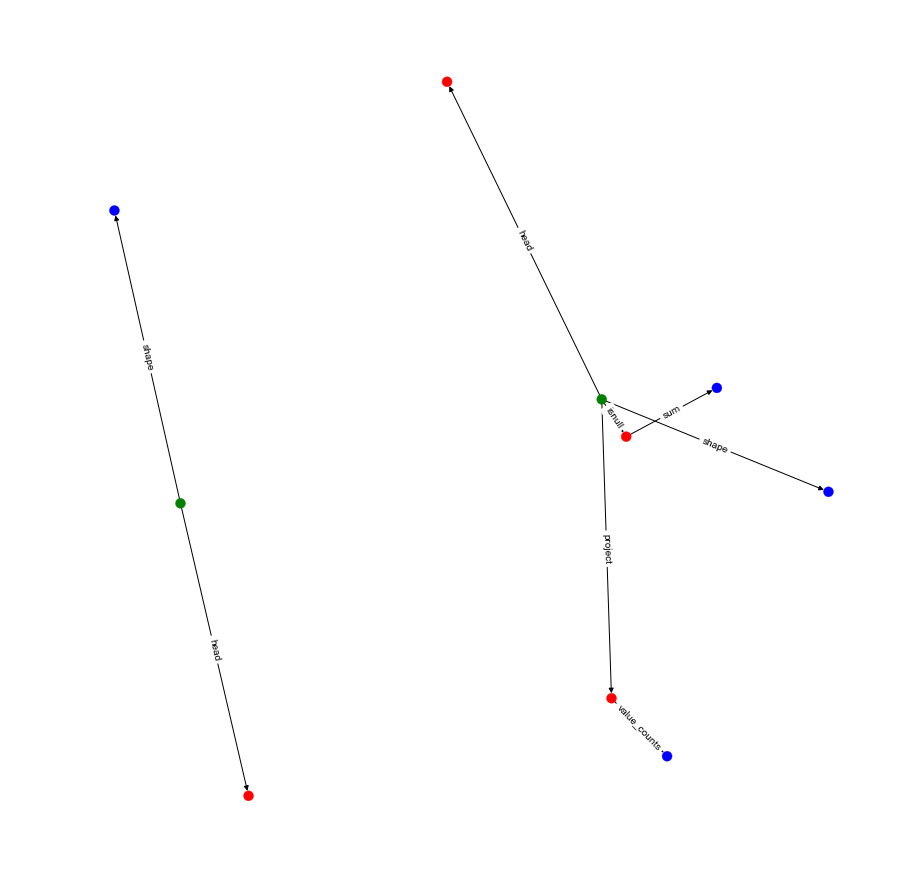

In [11]:
%%time
app_train.select_dtypes('object').nunique().get()

CPU times: user 349 ms, sys: 35 ms, total: 384 ms
Wall time: 384 ms


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Possbile Bottleneck
The repeated column drop and column add seems to take longer than it should (normal panda takes 541 ms but here it taks 1.55)

In [12]:
%%time
# Create a label encoder object
le = LabelEncoder()
le_count = 0

for col in app_train.select_dtypes('object').get().columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).get() <= 2:
        model = app_train[col].fit_sk_model(le)

        transformed_train = model.transform_col(app_train[col], col)
        app_train = app_train.replace_columns(col, transformed_train)

        transformed_test = model.transform_col(app_test[col], col)
        app_test = app_test.replace_columns(col, transformed_train)
            

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.
CPU times: user 1.09 s, sys: 409 ms, total: 1.5 s
Wall time: 1.51 s


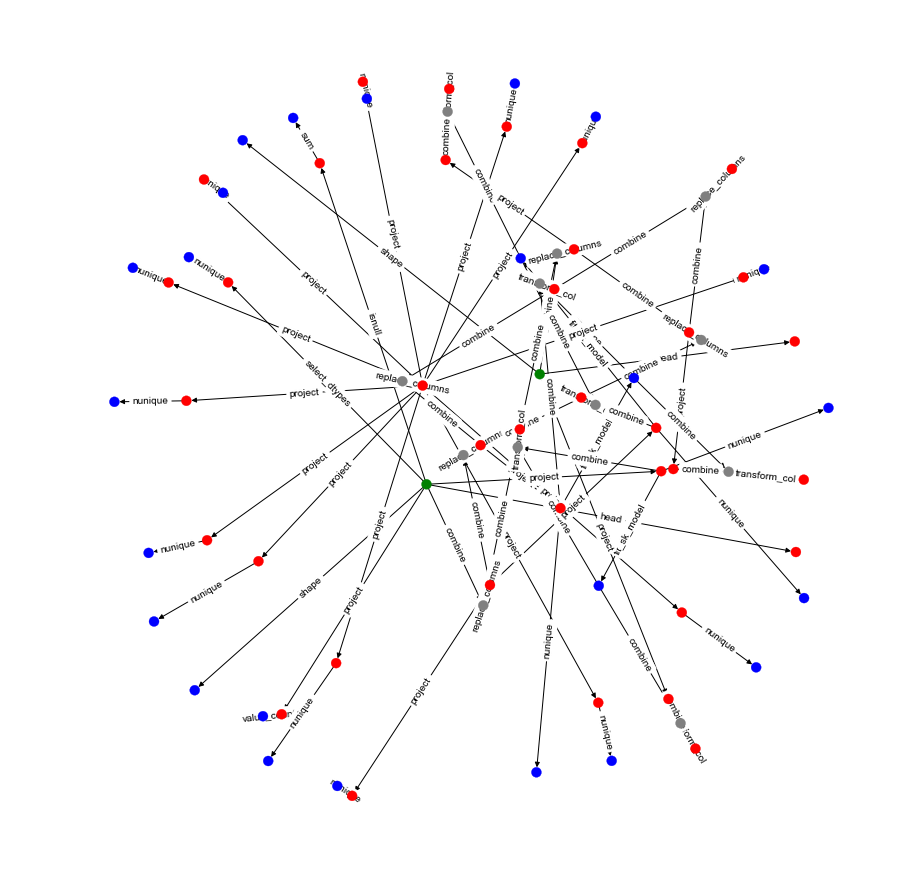

In [13]:
plot_graph()

In [12]:
%%time
app_train = app_train.onehot_encode()
app_test = app_test.onehot_encode()

print('Training Features shape: ', app_train.shape().get())
print('Testing Features shape: ', app_test.shape().get())

('Training Features shape: ', (307511, 243))
('Testing Features shape: ', (48744, 239))
CPU times: user 1.3 s, sys: 719 ms, total: 2.02 s
Wall time: 2.02 s


## Possible Bottleneck
The align operation of pandas are much faster than the repeated column dropping

In [13]:
%%time
train_labels = app_train['TARGET']
for c in app_train.get().columns:
    if c not in app_test.get().columns:
        app_train = app_train.drop(c)

app_train = app_train.add_columns('TARGET', train_labels)

print('Training Features shape: ', app_train.shape().get())
print('Testing Features shape: ', app_test.shape().get())

('Training Features shape: ', (307511, 240))
('Testing Features shape: ', (48744, 239))
CPU times: user 1.15 s, sys: 1.04 s, total: 2.18 s
Wall time: 2.21 s


In [14]:
%%time
(app_train['DAYS_BIRTH'] * 1.0/365).describe().get()

CPU times: user 40.5 ms, sys: 7.6 ms, total: 48.1 ms
Wall time: 44.7 ms


count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64

In [15]:
%%time
app_train['DAYS_EMPLOYED'].describe().get()

CPU times: user 34.2 ms, sys: 3.7 ms, total: 37.9 ms
Wall time: 35.5 ms


count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

CPU times: user 89.9 ms, sys: 7.91 ms, total: 97.8 ms
Wall time: 96.8 ms


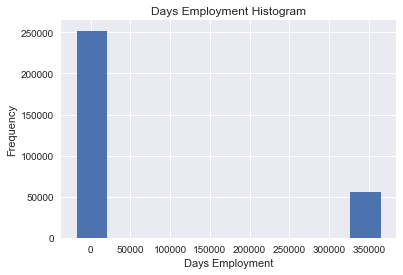

In [16]:
%%time
app_train['DAYS_EMPLOYED'].get().plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [17]:
%%time
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 *  non_anom['TARGET'].mean().get()))
print('The anomalies default on %0.2f%% of loans' % (100 *  anom['TARGET'].mean().get()))
print('There are %d anomalous days of employment' % anom.shape().get()[0])

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment
CPU times: user 396 ms, sys: 190 ms, total: 586 ms
Wall time: 583 ms


CPU times: user 490 ms, sys: 337 ms, total: 827 ms
Wall time: 955 ms


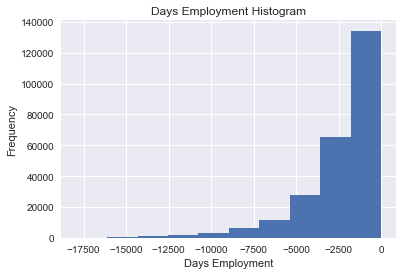

In [18]:
%%time
days_employed_anom = app_train["DAYS_EMPLOYED"] == 365243
app_train = app_train.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})
app_train = app_train.replace_columns('DAYS_EMPLOYED',temp)

app_train["DAYS_EMPLOYED"].get().plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')     

In [19]:
%%time
days_employed_anom = app_test["DAYS_EMPLOYED"] == 365243
app_test = app_test.add_columns( 'DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})
app_test = app_test.drop('DAYS_EMPLOYED')
app_test = app_test.replace_columns('DAYS_EMPLOYED', temp)
print('There are %d anomalies in the test data out of %d entries' 
      % (app_test['DAYS_EMPLOYED_ANOM'].sum().get(), 
         app_test.shape().get()[0]))

There are 9274 anomalies in the test data out of 48744 entries
CPU times: user 156 ms, sys: 67.9 ms, total: 223 ms
Wall time: 251 ms


In [20]:
%%time
correlations = app_train.corr().get()
top = correlations['TARGET'].sort_values()

#Display correlations
print('Most Positive Correlations:\n', top.tail(15))
print('\nMost Negative Correlations:\n', top.head(15))

('Most Positive Correlations:\n', OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64)
('\nMo

In [21]:
%%time
abs_age = app_train['DAYS_BIRTH'].abs()
app_train = app_train.replace_columns('DAYS_BIRTH', abs_age)
app_train['DAYS_BIRTH'].corr(app_train['TARGET']).get()

CPU times: user 187 ms, sys: 82.2 ms, total: 269 ms
Wall time: 265 ms


CPU times: user 140 ms, sys: 13.1 ms, total: 153 ms
Wall time: 146 ms


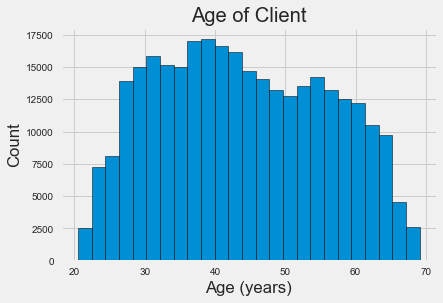

In [22]:
%%time
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist((app_train['DAYS_BIRTH']/365).get(), edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

CPU times: user 1.06 s, sys: 261 ms, total: 1.33 s
Wall time: 1.32 s


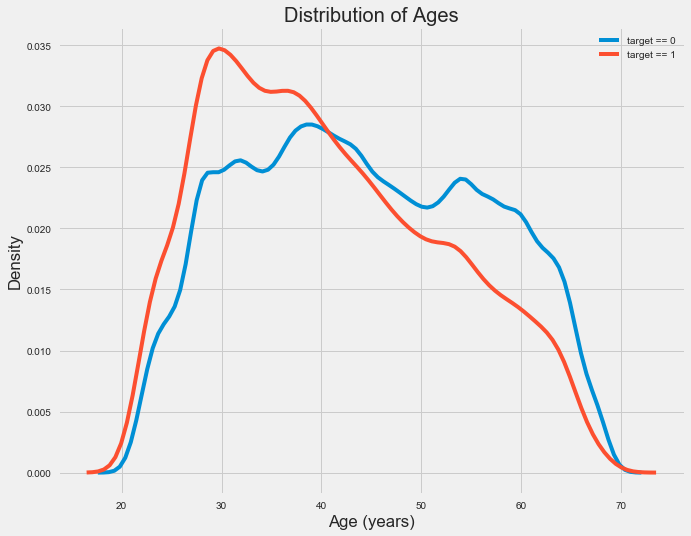

In [23]:
%%time
plt.figure(figsize = (10, 8))
# KDE plot of loans that were repaid on time
sns.kdeplot((app_train[app_train['TARGET'] == 0]['DAYS_BIRTH']/365).get(), label = 'target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot((app_train[app_train['TARGET'] == 1]['DAYS_BIRTH']/365).get(), label = 'target == 1')
# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [24]:
%%time
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data = age_data.add_columns('YEARS_BIRTH', age_data['DAYS_BIRTH'] / 365)

# Bin the age data
binned = age_data['YEARS_BIRTH'].binning(20, 70, 11)
age_data = age_data.add_columns('YEARS_BINNED', binned)
age_data.head(10).get()

CPU times: user 238 ms, sys: 16.4 ms, total: 255 ms
Wall time: 250 ms


In [25]:
%%time
# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups.get()

CPU times: user 217 ms, sys: 16.7 ms, total: 234 ms
Wall time: 227 ms


CPU times: user 53.5 ms, sys: 4.51 ms, total: 58 ms
Wall time: 54.8 ms


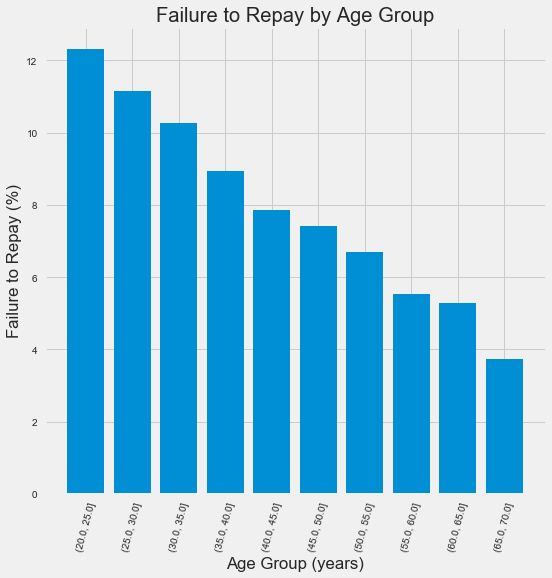

In [26]:
%%time
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.get().index.astype(str), age_groups.get()['TARGET'] * 100)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [27]:
%%time
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr().get()
print ext_data_corrs

                TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000
CPU times: user 237 ms, sys: 13.2 ms, total: 250 ms
Wall time: 247 ms


CPU times: user 111 ms, sys: 12.4 ms, total: 123 ms
Wall time: 121 ms


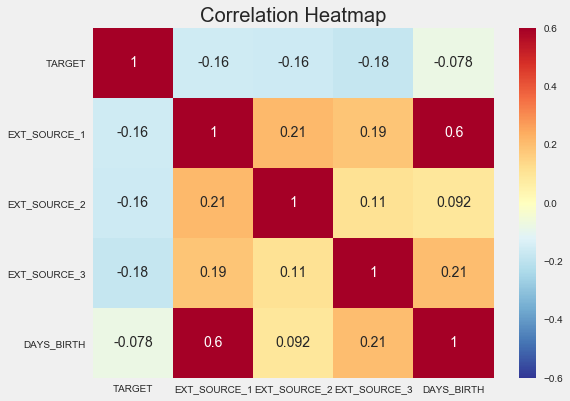

In [28]:
%%time
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

# Bottleneck
There may be some room for improvement here. It takes around twice as normal panda on the first run (3 vs 1.5 seconds)

CPU times: user 3.68 s, sys: 202 ms, total: 3.88 s
Wall time: 3.9 s


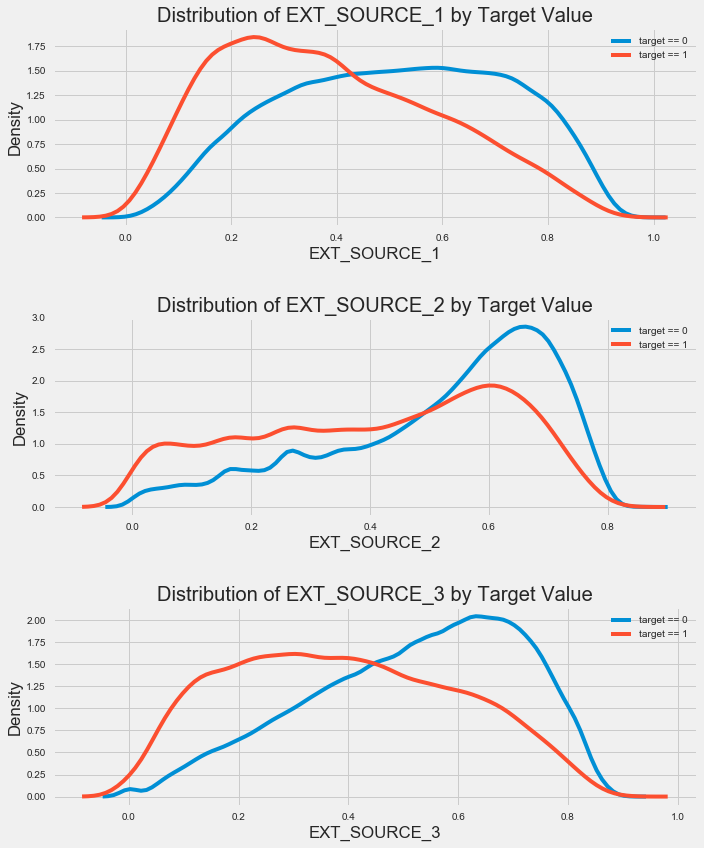

In [29]:
%%time
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, column in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 0]
    sns.kdeplot(source_data[app_train[column].notna()][column].get(), label = 'target == 0')
    # plot loans that were not repaid
    source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 1]
    sns.kdeplot(source_data[app_train[column].notna()][column].get(), label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % column)
    plt.xlabel('%s' % column); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

CPU times: user 1min 5s, sys: 8.11 s, total: 1min 13s
Wall time: 1min


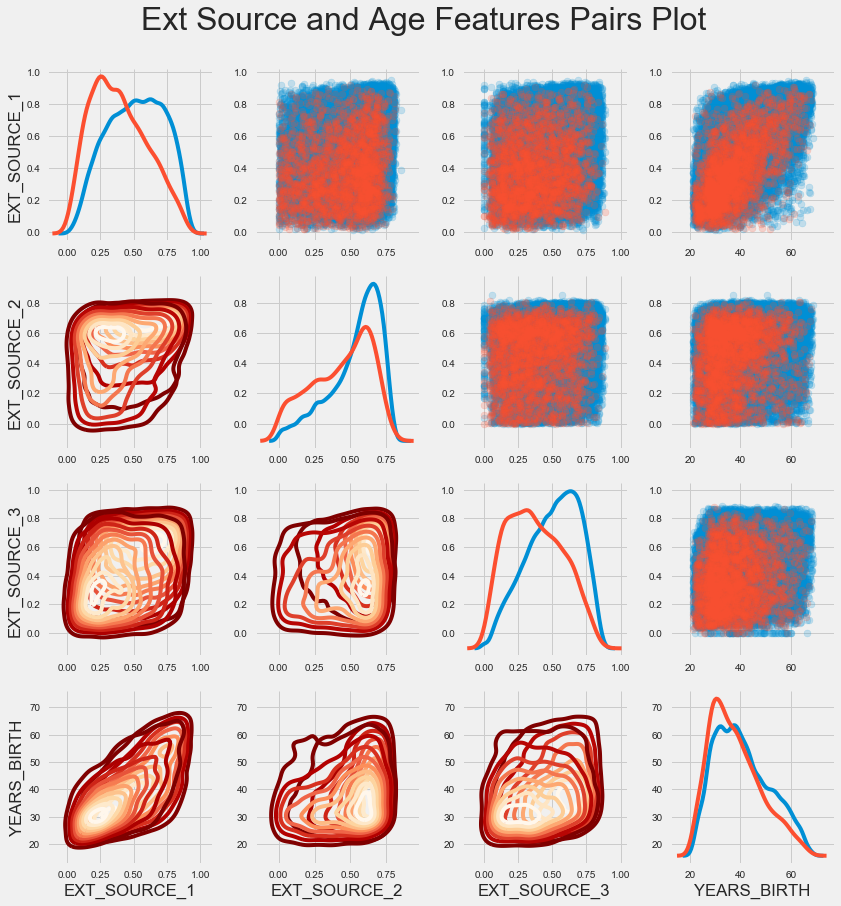

In [30]:
%%time
# Copy the data for plotting
plot_data = ext_data.drop('DAYS_BIRTH')

# Add in the age of the client in years
plot_data = plot_data.add_columns('YEARS_BIRTH', age_data['YEARS_BIRTH'])
# Drop na values and limit to first 100000 rows
plot_data = plot_data.head(100000).dropna()

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data.get(), size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.get().columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In [31]:
%%time
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
imputer_model = poly_features.fit_sk_model(imputer)
poly_features = imputer_model.transform(poly_features)
poly_features_test = imputer_model.transform(poly_features_test)

CPU times: user 3.25 ms, sys: 1.05 ms, total: 4.3 ms
Wall time: 3.37 ms


In [32]:
%%time
from sklearn.preprocessing import PolynomialFeatures
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer_model = poly_features.fit_sk_model(poly_transformer)

poly_features = poly_transformer_model.transform(poly_features)
poly_features_test = poly_transformer_model.transform(poly_features_test)

CPU times: user 2.19 ms, sys: 650 µs, total: 2.84 ms
Wall time: 2.37 ms


In [33]:
%%time
poly_transformer_model.get().get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])


CPU times: user 745 ms, sys: 43.5 ms, total: 788 ms
Wall time: 789 ms


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [34]:
%%time
# Call manually before meta data update
poly_features.get()
poly_features.set_columns(poly_transformer_model.get().get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features = poly_features.add_columns('TARGET', poly_target)

# Find the correlations with the target
poly_corrs = poly_features.corr().get()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64
CPU times: user 2.13 s, sys: 169 ms, total: 2.3 s
Wall time: 2.3 s


In [35]:
%%time
# Call manually before meta data update
poly_features_test.get()
poly_features_test.set_columns(poly_transformer_model.get().get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features = poly_features.add_columns('SK_ID_CURR', app_train['SK_ID_CURR'])
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test = poly_features_test.add_columns('SK_ID_CURR', app_test['SK_ID_CURR'])
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
for c in app_train_poly.get().columns:
    if c not in app_test_poly.get().columns:
        app_train_poly = app_train_poly.drop(c)


# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape().get())
print('Testing data with polynomial features shape:  ', app_test_poly.shape().get())

('Training data with polynomial features shape: ', (307511, 275))
('Testing data with polynomial features shape:  ', (48744, 275))
CPU times: user 5.3 s, sys: 1.68 s, total: 6.98 s
Wall time: 7.19 s


In [36]:
%%time
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain = app_train_domain.add_columns('CREDIT_INCOME_PERCENT', app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns('ANNUITY_INCOME_PERCENT', app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns('CREDIT_TERM', app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT'])
app_train_domain = app_train_domain.add_columns('DAYS_EMPLOYED_PERCENT', app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH'])


CPU times: user 6.95 ms, sys: 1.27 ms, total: 8.21 ms
Wall time: 7.14 ms


In [37]:
%%time
app_test_domain = app_test_domain.add_columns('CREDIT_INCOME_PERCENT', app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns('ANNUITY_INCOME_PERCENT', app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns('CREDIT_TERM', app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT'])
app_test_domain = app_test_domain.add_columns('DAYS_EMPLOYED_PERCENT', app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'])


CPU times: user 9.02 ms, sys: 2.62 ms, total: 11.6 ms
Wall time: 9.44 ms


## Bottleneck
The cell below takes surprisingly a long amount of time. Should figure out why

CPU times: user 1min 47s, sys: 2.43 s, total: 1min 50s
Wall time: 1min 50s


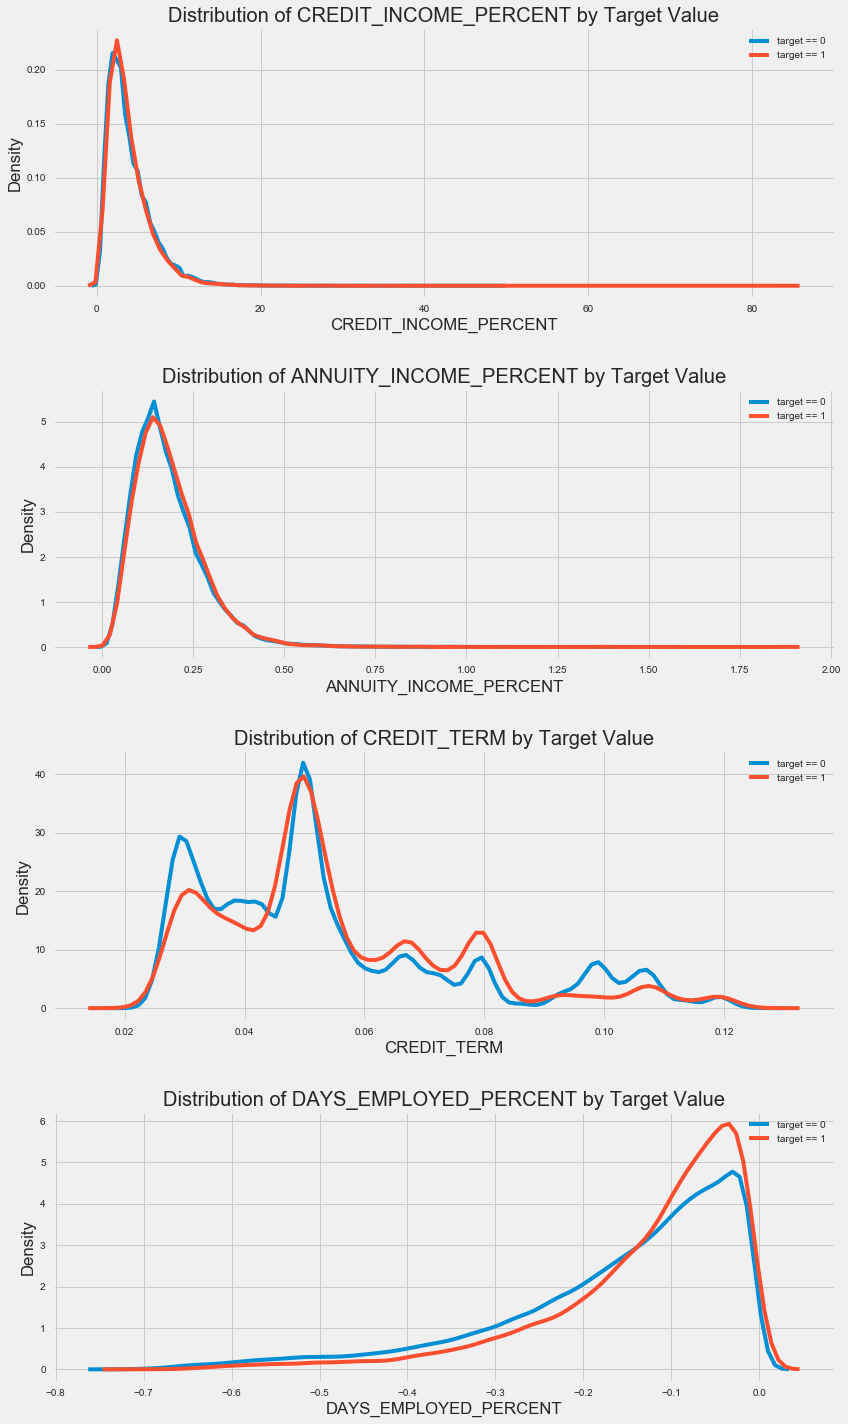

In [38]:
%%time
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, column in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    negative = app_train_domain[[column, 'TARGET']][app_train['TARGET'] == 0]
    sns.kdeplot(negative[app_train_domain[column].notna()][column].get(), label = 'target == 0')
    # plot loans that were not repaid
    positive = app_train_domain[[column, 'TARGET']][app_train['TARGET'] == 1]
    sns.kdeplot(positive[app_train_domain[column].notna()][column].get(), label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % column)
    plt.xlabel('%s' % column); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)


In [ ]:
%%time
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train.get().columns:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.get().columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
sk_imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
sk_scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer = train.fit_sk_model(sk_imputer)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler = train.fit_sk_model(sk_scaler)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape().get())
print('Testing data shape: ', test.shape().get())

('Training data shape: ', (307511, 240))


In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
sk_log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg = train.fit_sk_model_with_labels(sk_log_reg, train_labels)

In [ ]:
%%time
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[1]

In [ ]:
%%time
# Submission data
log_reg_pred.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(log_reg_pred)
submit.head().get()

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
sk_random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
%%time
# Train on the training data
random_forest = train.fit_sk_model_with_labels(sk_random_forest, train_labels)
domain_features_names = list(train.get().columns)

# Extract feature importances
feature_importances = random_forest.feature_importances(domain_features_names)

In [ ]:
%%time
# Make predictions on the test data
predictions = random_forest.predict_proba(test)[1]

In [ ]:
%%time
# Submission dataframe
predictions.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(predictions)

submit.head().get()

In [ ]:
%%time
poly_features_names = list(app_train_poly.get().columns)

# Impute the polynomial features
sk_imputer = Imputer(strategy = 'median')
imputer = app_train_poly.fit_sk_model(sk_imputer)
poly_features = imputer.transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
sk_scaler = MinMaxScaler(feature_range = (0, 1))
scaler = poly_features.fit_sk_model(sk_scaler)
poly_features = scaler.transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

sk_random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
%%time
# Train on the training data
random_forest_poly = poly_features.fit_sk_model_with_labels(sk_random_forest_poly, train_labels)

In [ ]:
# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[1]

In [ ]:
%%time
# Submission dataframe
predictions.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(predictions)

submit.head().get()

In [ ]:
%%time
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.get().columns)

# Impute the domainnomial features
sk_imputer = Imputer(strategy = 'median')

imputer = app_train_domain.fit_sk_model(sk_imputer)
domain_features = imputer.transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
sk_scaler = MinMaxScaler(feature_range = (0, 1))

scaler = domain_features.fit_sk_model(sk_scaler)
domain_features = scaler.transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

sk_random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
%%time
sk_random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest_domain = domain_features.fit_sk_model_with_labels(sk_random_forest_domain, train_labels)

# Extract feature importances
feature_importances_domain = random_forest_domain.feature_importances(domain_features_names)

In [ ]:
%%time
# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[1]

In [ ]:
%%time
# Submission dataframe
predictions.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(predictions)

submit.head().get()

In [ ]:
%%time
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False)
    
    # Normalize the feature importances to add up to one
    df = df.add_columns(df['importance'] / df['importance'].sum().get(), 'importance_normalized')

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.get().index[:15]))), 
            df['importance_normalized'].get().head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.get().index[:15]))))
    ax.set_yticklabels(df['feature'].get().head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
%%time
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [ ]:
%%time
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

In [ ]:
%%time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = features.onehot_encode()
        test_features = test_features.onehot_encode()
        
        # Align the dataframes by the columns
        for c in features.get().columns:
            if c not in test_features.get().columns:
                features = features.drop(c)
                
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder object
        le = LabelEncoder()
        # List for storing categorical indices
        cat_indices = []

        for i, col in enumerate(features.select_dtypes('object').get().columns):
            # we are not using nunique because it discard nan
            label_encoder = features[col].fit_sk_model(le)

            transformed_feature = features.transform_col(features[col], col)
            features = features.drop(col)
            features = features.add_columns(transformed_feature, col)

            transformed_feature_test = model.transform_col(test_features[col], col)
            test_features = test_features.drop(col)
            test_features = test_features.add_columns(transformed_feature_test, col)
            cat_indices.append(i)    
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape().get())
    print('Testing Data Shape: ', test_features.shape().get())
    
    # Extract feature names
    feature_names = list(features.get().columns)


    # Create the model
    lgb_model = lgb.LGBMClassifier(n_estimators=10, objective = 'binary', 
                               class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, 
                               subsample = 0.8, n_jobs = -1, random_state = 50)
        
    model = features.fit_sk_model_with_labels(lgb_model, labels, custom_args={'eval_metric':'auc',
                                                                             'categorical_feature':cat_indices,
                                                                             'verbose':200})    
        
    # Record the best iteration
    best_iteration = model.get().best_iteration_
    
        
    # Make predictions
    test_predictions = model.predict_proba(test_features, custom_args={'num_iteration':best_iteration})[1] 
        
    
    test_predictions.setname('TARGET')
    # Make the submission dataframe
    submission = test_ids.concat(test_predictions)
    
    feature_importances = model.feature_importances(feature_names)
   

    return submission, feature_importances

In [ ]:
%%time
submission, fi = model(app_train, app_test)

In [ ]:
%%time
fi_sorted = plot_feature_importances(fi)

In [ ]:
%%time
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain = model(app_train_domain, app_test_domain)

In [ ]:
%%time
fi_sorted = plot_feature_importances(fi_domain)